In [1]:
# hide
%reload_ext autoreload
%autoreload 2

In [26]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from dataFunction import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from run_simulations import run_simulations

random.seed(11007303)
np.random.seed(2021)

In [3]:
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [4]:
cleveland = "FL_HE_2/processed.cleveland.data"
switzerland = "FL_HE_2/processed.switzerland.data"
va = "FL_HE_2/processed.va.data"
hungarian = "FL_HE_2/reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)


In [5]:
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL = KL_matrices_disc_cont(clients, cat_bin_features, numeric_feature_names)
KL_mean = (np.array(KL)[np.triu_indices(len(clients), k=1)].mean() + np.array(KL)[np.tril_indices(len(clients), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results, net_best = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 300)
print(df_dict.keys())
print(clients[0].X.columns)
print(KL)
print('KL FL mean: {}'.format(KL_mean))
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.016075  2.445411
1  2.358766  0.000000  2.114656
2  1.519378  1.812092  0.000000
KL FL mean: 2.0443964321112524
Best model, iter: 19, acc: 0.8066666722297668


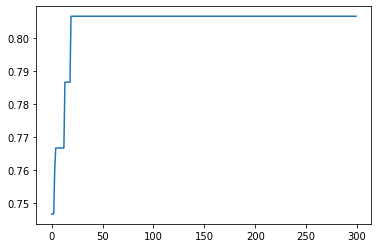

In [6]:
plt.plot(final_results.best_acc)
plt.show()

In [7]:
final_results

,epoch,loss_avg,loss_test,acc_test,best_acc
0,0.0,0.835889,0.876480,0.746667,0.746667
1,1.0,0.872098,4.384315,0.553333,0.746667
2,2.0,0.965533,2.124725,0.613333,0.746667
3,3.0,0.991791,0.842116,0.760000,0.760000
4,4.0,0.969246,0.920190,0.766667,0.766667
...,...,...,...,...,...
295,295.0,0.890091,0.879786,0.786667,0.806667
296,296.0,0.889919,0.884456,0.766667,0.806667
297,297.0,0.889554,0.874286,0.786667,0.806667
298,298.0,0.889213,0.957514,0.800000,0.806667


In [17]:
CI1 =  st.t.interval(alpha=0.95, df=len(final_results.best_acc)-1, loc=np.mean(final_results.best_acc), scale=st.sem(final_results.best_acc)) 
CI1

(0.8032094033320816, 0.8054128293434708)

In [18]:
CI2 =  st.t.interval(alpha=0.95, df=len(final_results_S.best_acc)-1, loc=np.mean(final_results_S.best_acc), scale=st.sem(final_results_S.best_acc)) 
CI2

(0.771046941765489, 0.7748197693741898)

In [23]:
(CI1[1]+CI2[1])/2

0.7901162993588303

In [24]:
np.mean([CI1, CI2], axis=0)

array([0.78712817, 0.7901163 ])

In [159]:
# for i in clients:
#     # print(i.X.Oldpeak)
#     xy = pd.concat([i.X, i.y], axis=1)
#     plt.figure(figsize=(12,10))
#     sns.heatmap(xy.corr(),annot=True,cmap="magma",fmt='.2f')
#     # print(xy)

In [9]:
df_dict_S ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_S = []

for i in list(df_dict_S.keys()):
    df = df_dict_S.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_S = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_S:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_S = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model_S)
    lr = 3
    lr_decay = 1
    clients_S.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_S = KL_matrices_disc_cont(clients_S, cat_bin_features, numeric_feature_names_S)
KL_mean_S = (np.array(KL_S)[np.triu_indices(len(clients_S), k=1)].mean() + np.array(KL_S)[np.tril_indices(len(clients_S), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_S:
    i.make_dummies(cat_feat)
val_x_S, val_y_S = make_validation_sets(clients_S)

best_epoch_S, best_acc_S, model_dict_S, final_results_S = FL_proces(clients_S, val_x_S, val_y_S, ctx_eval, glob_model_S, 300)
print(df_dict_S.keys())
print(clients_S[0].X.columns)
print(KL_S)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_S, best_acc_S))  


dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'FastingBS', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ChestPainType_1', 'ChestPainType_4', 'ChestPainType_3',
       'ChestPainType_2', 'RestingECG_2', 'RestingECG_0', 'RestingECG_1',
       'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2         3
0  0.000000  1.548866  2.016075  2.445411
1  1.371031  0.000000  0.662388  1.171660
2  2.358766  0.830447  0.000000  2.114656
3  1.519378  1.188149  1.812092  0.000000
KL FL mean: 1.5865767504716217
Best model, iter: 62, acc: 0.7771428823471069


In [171]:
final_results_S.iloc[[18]]

,epoch,loss_avg,loss_test,acc_test,best_acc
18,18.0,0.782792,0.836189,0.777143,0.777143


In [172]:
final_results.iloc[[88]]

,epoch,loss_avg,loss_test,acc_test,best_acc
88,88.0,0.900472,0.835933,0.813333,0.813333


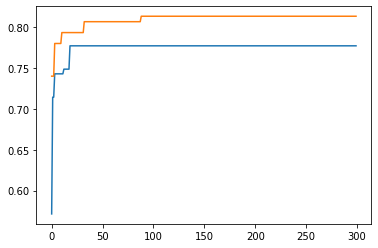

In [173]:
plt.plot(final_results_S.best_acc)
plt.plot(final_results.best_acc)
plt.show()

In [190]:
# Plot predicted vs test!

import plotly.graph_objects as go
glob_model_S.load_state_dict(model_dict_S)
y_pred = glob_model_S(val_x_S).detach().numpy()
y_test = val_y

y_pred_round = round(y_pred)

# fig = go.Figure()
 
 
# # fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
# #                     mode='markers',
# #                     name='Test'))
# fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
#                     mode='markers',
#                     name='Pred'))

TypeError: type numpy.ndarray doesn't define __round__ method

In [34]:
N_Clients = [2, 5]
N_Features = [2]
N_Observations = [10]
monte_carlo_reps = [10]
mean_distance = [1]
epsilon_sigmas = [1]
run_simulations(N_Clients, N_Features, N_Observations, monte_carlo_reps, mean_distance, epsilon_sigmas)

inter:0, mean dist: 1, n_observation:10, n_clients:2, n_features:2, mc:10, epsilon_sigma:1
Best model, iter: 14, acc: 0.7400000095367432
inter:1, mean dist: 1, n_observation:10, n_clients:5, n_features:2, mc:10, epsilon_sigma:1
Best model, iter: 4, acc: 0.8199999928474426


{0: {'parameters': {'n_clients': 2,
   'n_features': 2,
   'n_observations': 10,
   'mean_dist': 1,
   'epsilon_sigma': 1},
  'results': {'acc_CI_mean': array([0.73332389, 0.73887612]),
   'KL_mean': 0.0,
   'acc_mean': 0.7400000095367432}},
 1: {'parameters': {'n_clients': 5,
   'n_features': 2,
   'n_observations': 10,
   'mean_dist': 1,
   'epsilon_sigma': 1},
  'results': {'acc_CI_mean': array([0.81878082, 0.82001916]),
   'KL_mean': -2.2204460492503132e-17,
   'acc_mean': 0.8199999928474426}}}

In [187]:
round(0.4)

0